### Build LLM judge to choose which model is preferred

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os
from hellofresh_extractor.llm.StructuredGeminiCaller import StructuredGeminiCaller
from hellofresh_extractor.gsuite.drive.GoogleDriveHelper import GoogleDriveHelper
from hellofresh_extractor.llm.StructuredClaudeCaller import StructuredClaudeCaller
from hellofresh_extractor.llm.prompts import multimodal_system_prompt, multimodal_user_query, judge_compare_prompt
from hellofresh_extractor.llm.output_schemas import JudgeModel
import glob
from PIL import Image
from pillow_heif import register_heif_opener
from dotenv import load_dotenv
import time
import numpy as np
import pandas as pd
from pydantic import BaseModel, Field
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context("notebook")

In [3]:
load_dotenv()

True

In [4]:
this_path = os.getcwd()
images_path = os.path.join(this_path,"images")

In [5]:
images = glob.glob(os.path.join(images_path,"*.HEIC"))

In [6]:
dataset_compare = pd.read_csv("test_hello_fresh_recipes_joined.csv")

In [7]:
gemini_caller = StructuredGeminiCaller(
    api_key=os.environ.get("GEMINI_API_KEY"),
    model="gemini-2.5-flash-preview-04-17"
)

claude_caller = StructuredClaudeCaller(
    api_key=os.environ.get("ANTHROPIC_API_KEY"),
    model="claude-3-7-sonnet-latest"
)

In [8]:
dataset_compare.head()

,image_id,recipe_gemini,recipe_local
0,/Users/rmartinshort/Documents/DS_projects/gemm...,\nCreamy Dijon Dill Chicken with Roasted Potat...,\nCreamy Dijon Dill Chicken with Roasted Potat...
1,/Users/rmartinshort/Documents/DS_projects/gemm...,\nSour Cream & Onion Chicken with Mashed Potat...,\nSour Cream & Onion Chicken\nPreparation time...
2,/Users/rmartinshort/Documents/DS_projects/gemm...,\nSweet Chili Turkey & Green Bean Bowls\nPrepa...,\nSweet Chili Turkey & Green Bean Bowls\nPrepa...
3,/Users/rmartinshort/Documents/DS_projects/gemm...,\nMeatballs with Bulgogi Sauce plus Roasted Ca...,\nMeatballs with Bulgogi Sauce plus Roasted Ca...
4,/Users/rmartinshort/Documents/DS_projects/gemm...,\nRIGATONI WITH BEEF & ZUCCHINI RAGÙ plus Parm...,\nRigatoni with Beef & Zucchini Ragù\nPreparat...


In [91]:
all_meals = []
register_heif_opener()
t0 = time.time()
judge_result = defaultdict(list)
recipe_choices = ["recipe_local","recipe_gemini"]
for i, row in dataset_compare.iterrows():
    print("*"*30)
    print(f"At image {i}")
    image = row["image_id"]
    recipe_choice_A = np.random.choice(np.arange(len(recipe_choices)))
    recipe_choice_B = 0 if recipe_choice_A == 1 else 1
    recipe_A = row[recipe_choices[recipe_choice_A]]
    recipe_B = row[recipe_choices[recipe_choice_B]]

    choice_dict = {
        "A": recipe_choices[recipe_choice_A],
        "B": recipe_choices[recipe_choice_B]
    }

    print(choice_dict)
    
    open_image = Image.open(image).convert("RGB")

    model_A = f"""
    Model A's result was
    {recipe_A}
    """

    model_B = f"""
    Model A's result was
    {recipe_B}
    """
    
    # result = gemini_caller.invoke(
    #     system_message=judge_compare_prompt,
    #     input_content=[open_image, model_A, model_B, "Please judge the results according to the instructions"],
    #     output_schema=JudgeModel
    # )

    result = claude_caller.invoke(
        system_message=judge_compare_prompt,
        input_content=[open_image, model_A, model_B, "Please judge the results according to the instructions. Remember to always return valid JSON like this example {'winner':'A','reasoning':'Model A is the best'}"],
        output_schema=JudgeModel
    )

    if "structured_data" in result:
        analysis = result["structured_data"]
        judge_result['winner'].append(choice_dict.get(analysis["winner"],"tie"))
        judge_result['reasoning'].append(analysis["reasoning"])
        print(analysis)
        #df = convert_structured_result_to_df(analysis)
        #df["image_path"] = image
        #all_meals.append(df)
    else:
        print(f"Structured data field not found for result {result}")
t1 = time.time()
mean_process_time = (t1 - t0)/len(images)

******************************
At image 0
{'A': 'recipe_local', 'B': 'recipe_gemini'}
{'winner': 'B', 'reasoning': 'Model B extracted the ingredients and amounts more accurately than Model A.'}
******************************
At image 1
{'A': 'recipe_gemini', 'B': 'recipe_local'}
{'winner': 'A', 'reasoning': 'Model A extracted the correct amount for scallions and sour cream.'}
******************************
At image 2
{'A': 'recipe_gemini', 'B': 'recipe_local'}
{'winner': 'A', 'reasoning': 'Model A extracted all the ingredients and amounts correctly. Model B missed several ingredients and amounts.'}
******************************
At image 3
{'A': 'recipe_gemini', 'B': 'recipe_local'}
{'winner': 'A', 'reasoning': 'Model A extracted all the ingredients and amounts correctly. Model B missed several ingredients.'}
******************************
At image 4
{'A': 'recipe_gemini', 'B': 'recipe_local'}
{'winner': 'A', 'reasoning': 'Model A extracted all ingredients and amounts correctly. Model 

In [92]:
judge_result_pd = pd.DataFrame(judge_result)

In [93]:
judge_result_pd.to_csv("test_hello_fresh_recipes_judge_result_Gemini.csv")

In [99]:
judge_result_pd = pd.read_csv("test_hello_fresh_recipes_judge_result_Claude.csv")

/var/folders/bk/t1x8_7vs3bl6196t1y3p4hb40000gn/T/ipykernel_96153/2693510198.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


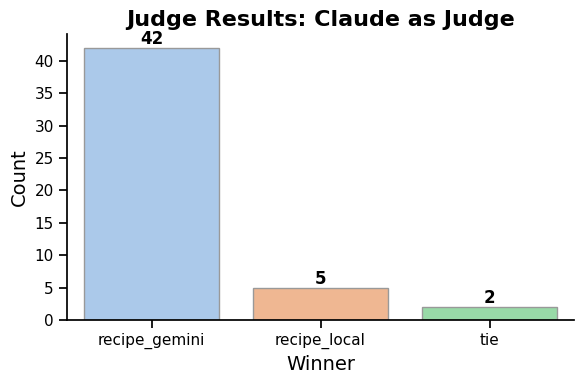

In [101]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x="winner",
    data=judge_result_pd,
    palette="pastel",
    edgecolor=".6"
)

# Add value labels on top of each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        str(count),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom',
        fontsize=12, fontweight='bold'
    )

ax.set_title("Judge Results: Claude as Judge", fontsize=16, fontweight='bold')
ax.set_xlabel("Winner", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()